#### Purpose : E. MODEL EVALUATION 

In the model evaluation phase, each trained classifier is assessed using a comprehensive set of performance metrics to ensure robustness, reliability, and fairness. Accuracy provides an overall measure of correct predictions, while Precision and Recall offer deeper insights into how well the model handles class-specific errors particularly important for imbalanced datasets. The F1-score combines Precision and Recall into a single harmonic mean, making it ideal when misclassification costs differ across categories. Additionally, ROC-AUC (one-vs-rest) evaluates the model’s ability to distinguish between the three classes across various threshold settings, offering a threshold-independent performance measure. Finally, confusion matrices are generated to visualize class-level prediction patterns, highlight misclassification trends, and support deeper diagnostic analysis. This multi-metric evaluation ensures that model comparison is thorough, interpretable, and aligned with the project’s objective of building a reliable student performance prediction system.

In [1]:
%run 00_project_setup.ipynb
%run 01_data_import.ipynb 
%run 04_feature_engineering.ipynb

In [2]:
%run 05_model_training.ipynb

Original: (4424, 15)
After outlier removal: (4335, 15)

Training SVM...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters for SVM: {'clf__C': 10, 'clf__gamma': 'scale', 'clf__kernel': 'linear'}
Best CV Weighted F1 Score: 0.7490

Training LogisticRegression...
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best parameters for LogisticRegression: {'clf__C': 10, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}
Best CV Weighted F1 Score: 0.7455

Training RandomForest...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters for RandomForest: {'clf__max_depth': 10, 'clf__min_samples_split': 5, 'clf__n_estimators': 200}
Best CV Weighted F1 Score: 0.7507

Training XGBoost...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters for XGBoost: {'clf__learning_rate': 0.1, 'clf__max_depth': 3, 'clf__n_estimators': 100}
Best CV Weighted F1 Score: 0.7575

Training GradientBoosting...
Fitting 5 folds for each of 8 candid

In [3]:
# -----------------------------
# Model Evaluation
# -----------------------------
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test) if hasattr(model, "predict_proba") else None
    
    metrics = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, average="weighted"),
        "Recall": recall_score(y_test, y_pred, average="weighted"),
        "F1-score": f1_score(y_test, y_pred, average="weighted"),
        "Confusion_Matrix": confusion_matrix(y_test, y_pred)
    }
    
    # ROC-AUC for multi-class (one-vs-rest)
    if y_prob is not None:
        lb = LabelBinarizer()
        y_test_bin = lb.fit_transform(y_test)
        metrics["ROC-AUC"] = roc_auc_score(y_test_bin, y_prob, average="weighted", multi_class="ovr")
    else:
        metrics["ROC-AUC"] = "Not available"
    
    return metrics


In [4]:

# Evaluate all models
evaluation_results = {}
for name, model in best_models.items():
    print(f"\nEvaluating {name}...")
    eval_metrics = evaluate_model(model, X_test, y_test)
    evaluation_results[name] = eval_metrics
    for metric, value in eval_metrics.items():
        print(f"{metric}: {value}")
    print('---------------------------------------------------------------------')


Evaluating SVM...
Accuracy: 0.7604519774011299
Precision: 0.7590194257941018
Recall: 0.7604519774011299
F1-score: 0.7520272345427266
Confusion_Matrix: [[190  47  47]
 [ 21  70  68]
 [ 10  19 413]]
ROC-AUC: 0.8851166553246491
---------------------------------------------------------------------

Evaluating LogisticRegression...
Accuracy: 0.7661016949152543
Precision: 0.7514094737663617
Recall: 0.7661016949152543
F1-score: 0.7512320754349571
Confusion_Matrix: [[209  31  44]
 [ 35  55  69]
 [ 10  18 414]]
ROC-AUC: 0.8902017047693969
---------------------------------------------------------------------

Evaluating RandomForest...
Accuracy: 0.7649717514124293
Precision: 0.7488725969196088
Recall: 0.7649717514124293
F1-score: 0.7486635568021132
Confusion_Matrix: [[209  27  48]
 [ 42  54  63]
 [ 12  16 414]]
ROC-AUC: 0.9004884435334574
---------------------------------------------------------------------

Evaluating XGBoost...
Accuracy: 0.7774011299435029
Precision: 0.7707087543523538
Recall

In [8]:
# Plot Confusion Matrix
# -----------------------------
def plot_confusion_matrix(cm, classes, title="Confusion Matrix", figsize=(6,5)):
    SAVE_PATH = os.path.join("..","outputs", "figures", "correlation_heatmap.png")
    plt.figure(figsize=figsize)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.title(title)
    plt.savefig(SAVE_PATH , dpi=300 , bbox_inches='tight')
    plt.show()

In [ ]:
# -----------------------------
# Plot ROC-AUC for multi-class (one-vs-rest)
# -----------------------------
def plot_roc_auc(model, X_test, y_test, title="ROC-AUC Curve"):
    SAVE_PATH = os.path.join("..","outputs", "figures", "correlation_heatmap.png")
    if not hasattr(model, "predict_proba"):
        print(f"ROC-AUC not available for {model}")
        return
    
    lb = LabelBinarizer()
    y_test_bin = lb.fit_transform(y_test)
    y_prob = model.predict_proba(X_test)
    n_classes = y_prob.shape[1]
    
    plt.figure(figsize=(8,6))
    
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f"Class {lb.classes_[i]} (AUC = {roc_auc:.2f})")
    
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.savefig(SAVE_PATH , dpi=300 , bbox_inches='tight')  
    plt.show()



Visualizing SVM...


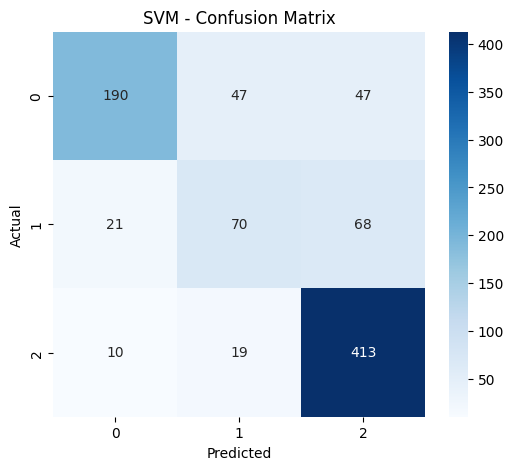

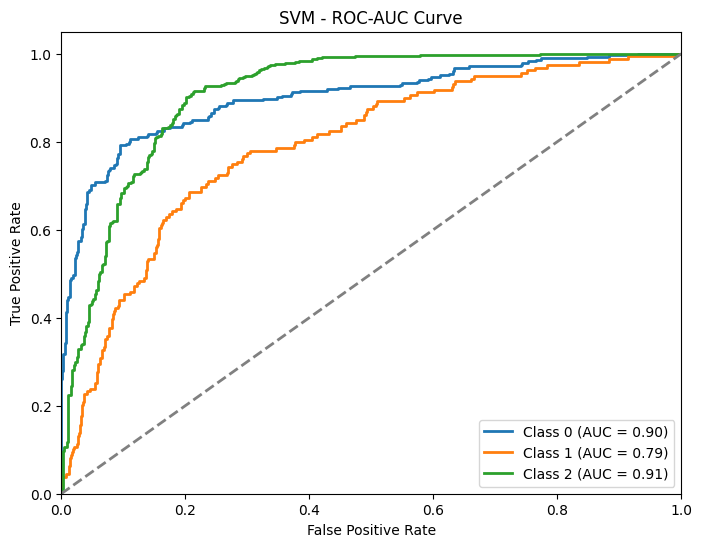


Visualizing LogisticRegression...


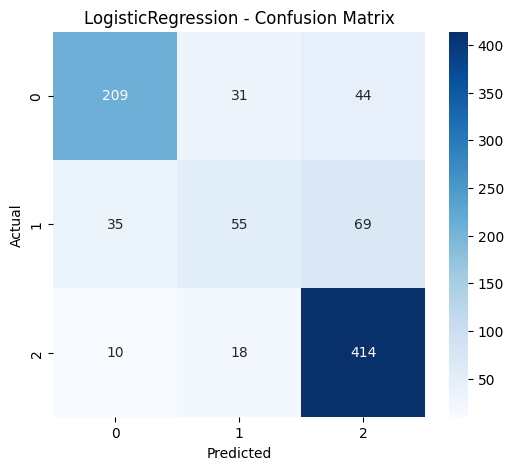

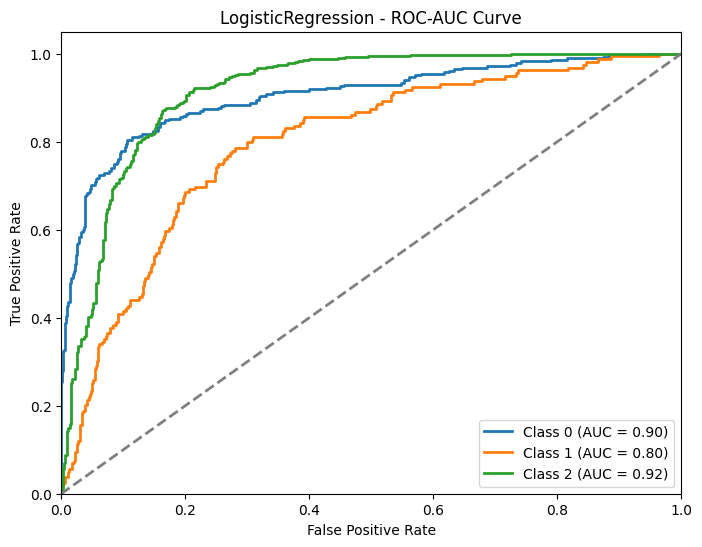


Visualizing RandomForest...


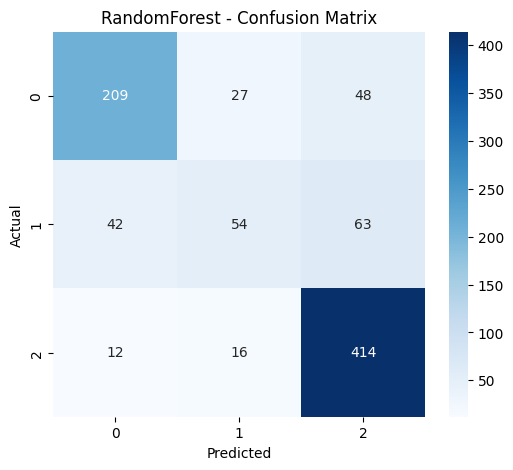

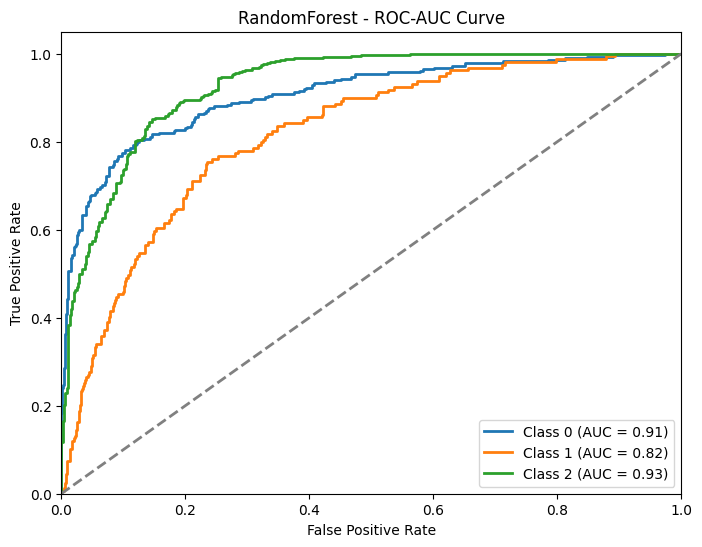


Visualizing XGBoost...


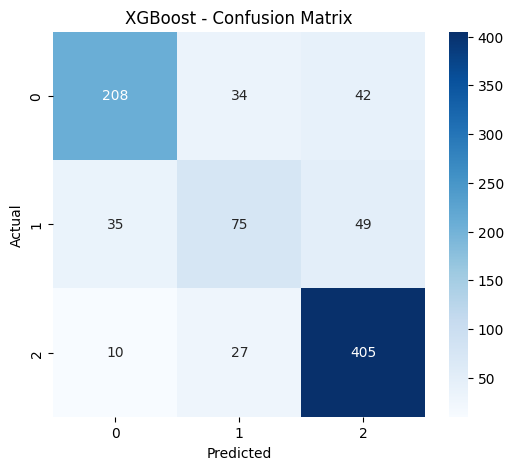

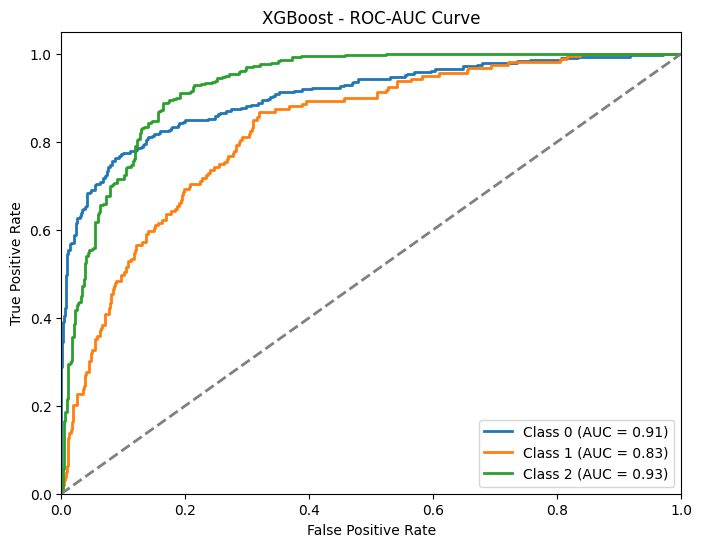


Visualizing GradientBoosting...


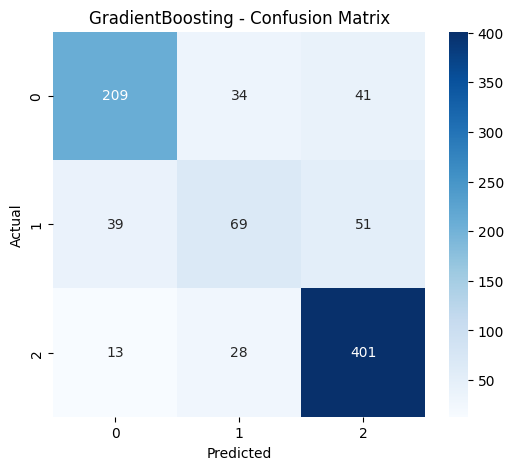

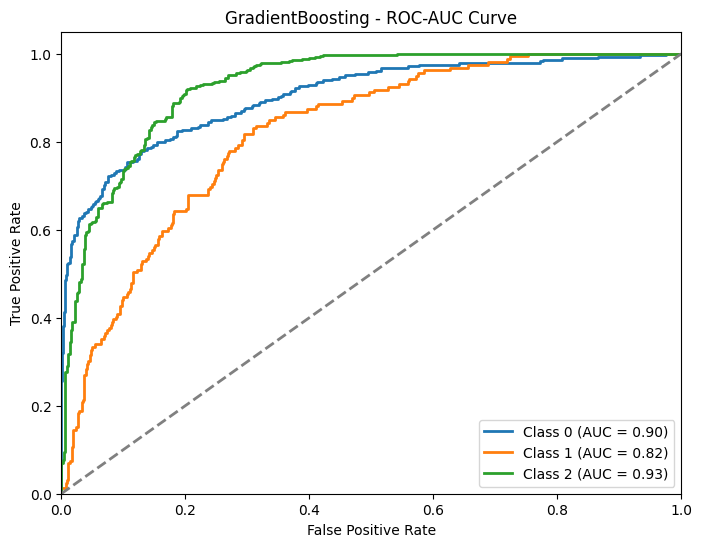

In [7]:
# -----------------------------
# Visualize all models
# -----------------------------
for name, model in best_models.items():
    print(f"\nVisualizing {name}...")
    eval_metrics = evaluation_results[name]
    
    # Confusion Matrix
    plot_confusion_matrix(eval_metrics["Confusion_Matrix"], classes=np.unique(y_test), title=f"{name} - Confusion Matrix")
    
    # ROC-AUC
    plot_roc_auc(model, X_test, y_test, title=f"{name} - ROC-AUC Curve")